# Preparativos

In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import sys
sys.path.append("../scripts")

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [148]:
plt.rcParams["figure.figsize"] = (14,4)

##### Carga de datos

In [149]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [150]:
data.head()

tiempo  nro factura    cliente categoria  tipo negocio localidad  \
0 2017-05-29     93315173  200008870        a5     mayorista  santa fe   
1 2017-06-14     93368453  200008870        a5     mayorista  santa fe   
2 2017-02-21     93074208  200008889        a3  supermercado  santa fe   
3 2017-05-11     93270490  200008889        a3  supermercado  santa fe   
4 2017-05-24     93309184  200008889        a3  supermercado  santa fe   

           direccion plaza/campaña  producto  nro pedido  ... u pedidas  \
0  av del valle 7199         plaza     90746     2736812  ...         1   
1  av del valle 7199         plaza     90746     2765668  ...         1   
2      gral.paz 5374         plaza     90740     2546672  ...         2   
3      gral.paz 5374         plaza     90746     2702464  ...         1   
4      gral.paz 5374         plaza     90746     2732609  ...         1   

   kg pedidos  fecha liq u entregadas  kg entregados  importe bruto  \
0       1.250 2017-05-29            1          1.250         231.70   
1       1.250 2017-06-14            1          1.250         231.70   
2       1.464 2017-02-21            2          1.464         324.96   
3       1.250 2017-05-11            1          1.250         231.70   
4       1.250 2017-05-24            1          1.250         231.70   

   importe factura  sucursal   longitud    latitud  
0         12421.88  santa fe -60.691979 -31.602638  
1         19944.84  santa fe -60.691979 -31.602638  
2         24534.07  santa fe -60.686356 -31.620964  
3         27204.63  santa fe -60.686356 -31.620964  
4         16573.12  santa fe -60.686356 -31.620964  

[5 rows x 21 columns]

# Pronóstico por producto

Ahora armamos la tabla con los pedidos por día por producto.

In [151]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [152]:
u_producto.head()

producto    16034  16061  16062  16070  16071  16075  16076  16077  16080  \
tiempo                                                                      
2017-01-02    NaN    7.0    1.0   25.0   11.0    3.0    NaN    NaN    NaN   
2017-01-03    NaN   21.0    NaN   27.0    2.0    NaN    NaN    NaN    NaN   
2017-01-04    NaN    NaN    NaN    8.0    4.0    NaN    1.0    NaN    NaN   
2017-01-05    NaN    3.0    NaN    6.0    3.0    NaN    NaN    NaN    NaN   
2017-01-06    NaN    NaN    2.0   17.0    NaN    NaN    NaN    NaN    NaN   

producto    16081  ...  44151  44152  44154  44155  44157  44158  90739  \
tiempo             ...                                                    
2017-01-02    1.0  ...    NaN    NaN    NaN    1.0    NaN    NaN    4.0   
2017-01-03    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    3.0   
2017-01-04    NaN  ...    NaN    NaN    NaN    1.0    NaN    1.0    NaN   
2017-01-05    NaN  ...    NaN    NaN    NaN   10.0    NaN    1.0    NaN   
2017-01-06    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

producto    90740  90745  90746  
tiempo                           
2017-01-02    1.0    NaN    NaN  
2017-01-03    2.0    NaN    NaN  
2017-01-04    NaN    NaN    NaN  
2017-01-05    1.0    NaN    NaN  
2017-01-06    NaN    NaN    NaN  

[5 rows x 64 columns]

Falta la fecha 01/01/2017. Por una cuestión de consistencia la agregamos al indice, aunque las observaciones sean todas NA.

In [153]:
u_producto = u_producto.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

Graficamos las series temporales de cada uno de los productos.

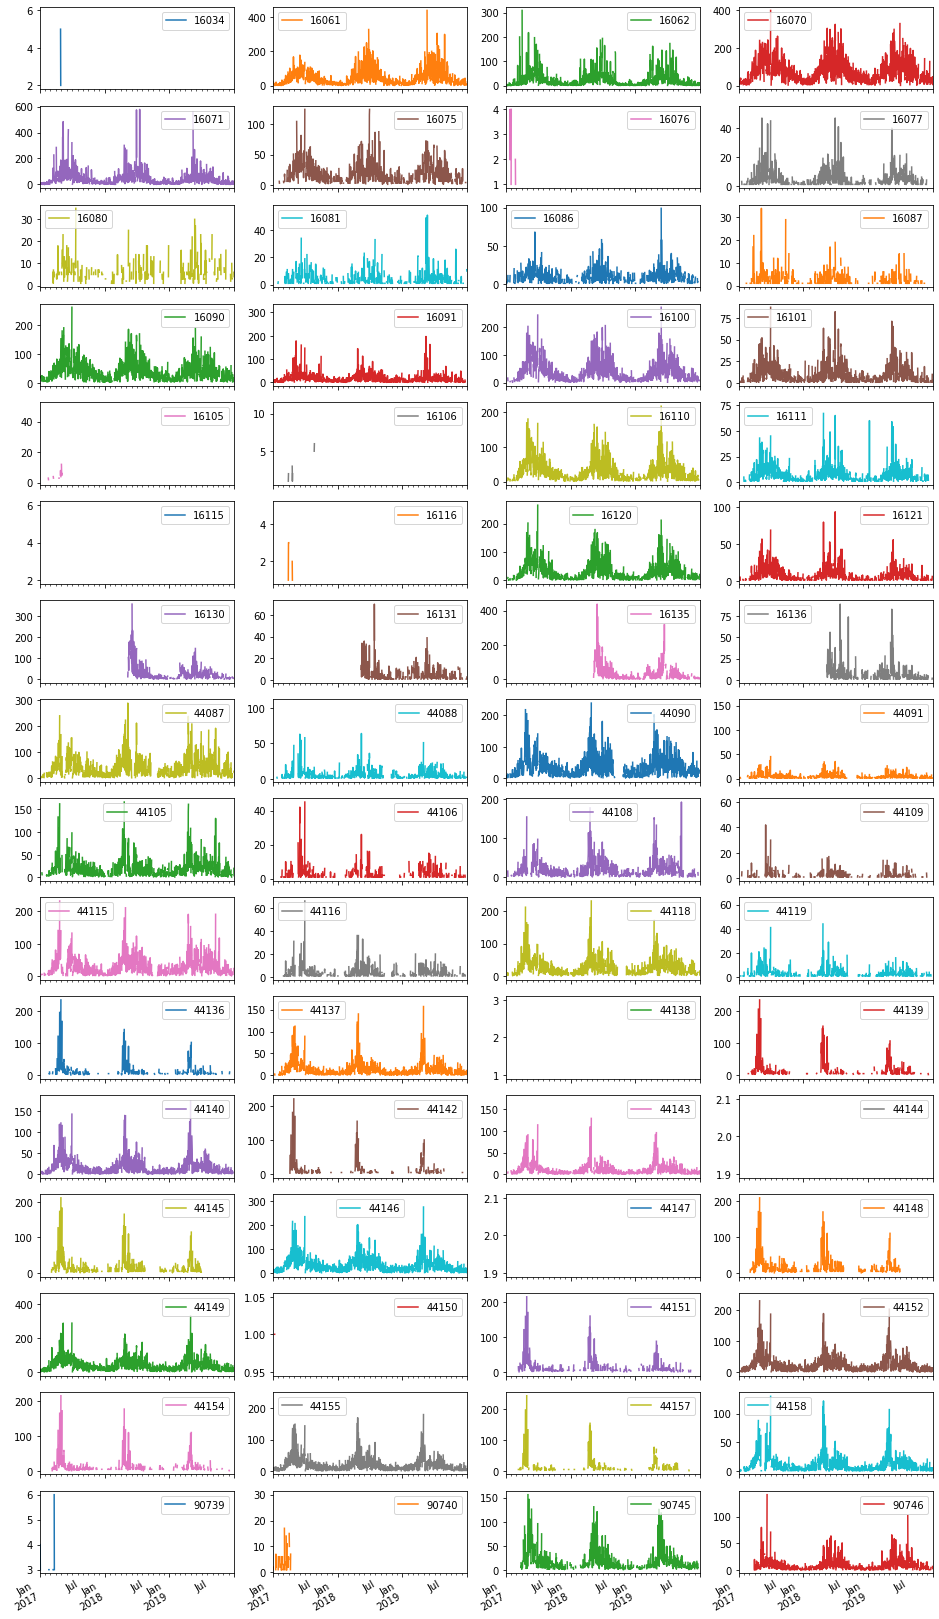

In [154]:
utils.plot_grid(u_producto, n_cols=4, figsize=(16,32))

Hay productos que presentan muy pocos pedidos durante este período como para hacer un pronóstico. Podemos calcular la cantidad de observaciones no nulas sobre el total de observaciones para obtener una representación de la proporción de "información" disponible en cada serie, como graficamos a continuación.

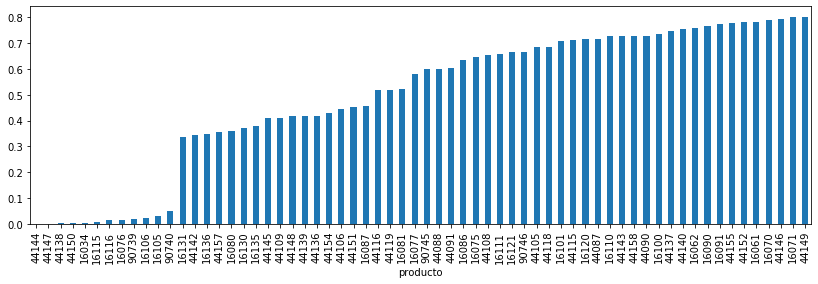

In [155]:
utils.get_amount_info(u_producto).plot(kind="bar")

Podemos asignar un umbral T, a partir del cual consideramos que la serie es apta para ser pronosticada. Para los ejemplos que siguen vamos a elegir T=0.5 y vamos a quedarnos con 6 series.

In [156]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=6)

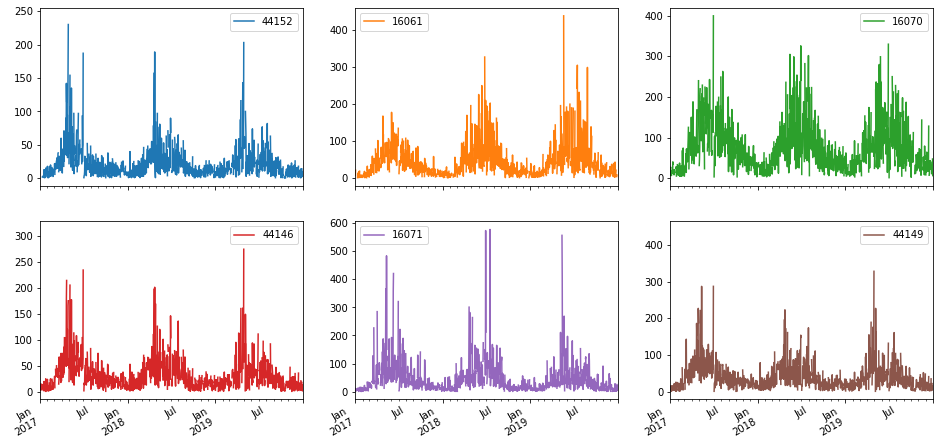

In [157]:
utils.plot_grid(u_producto_forecastable, n_cols=3, figsize=(16, 8))

Tomamos los dos primeros años como conjunto de entrenamiento y el último como prueba.

In [158]:
train_orig, test_orig = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

Cargamos un indicador económico, obtenido a partir del precio de la nafta, para usar como regresor en algunos de los ejemplos.

In [159]:
indicador_orig = pd.read_csv("../data/indicador_económico.csv", parse_dates=["fecha"]).set_index("fecha")

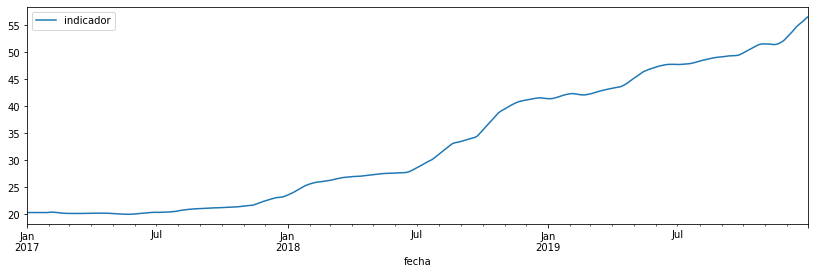

In [160]:
indicador_orig.plot()

## Pronóstico diario

In [161]:
from forecaster import ProphetForecaster

In [162]:
train = train_orig.copy()
test = test_orig.copy()

Realizamos un pronóstico diario de cada una de las series, un año hacia adelante, con intervalos de confianza del 80%.

In [163]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


El resultado es un DataFrame con la predicción y cotas inferiores y superiores para cada producto, abarcando el período de entrenamiento y el período de pronóstico. A continuación mostramos algunas filas.

In [164]:
fcst.head()

16061                            16070                        \
                yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper   
ds                                                                            
2017-01-02  7.607492   1.775860  21.728661  18.882908   5.104298  47.523893   
2017-01-03  7.655358   2.210087  21.463867  18.468423   5.238950  45.863909   
2017-01-04       NaN        NaN        NaN  18.132702   4.804153  46.419954   
2017-01-05  7.752606   2.278007  21.778922  17.871038   4.956851  48.716827   
2017-01-06       NaN        NaN        NaN  17.677949   5.428236  45.898155   

               16071                           44146                        \
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.443757   2.057592  22.536586  8.136911   2.586335  22.162642   
2017-01-03  7.226782   1.951750  22.738478  7.933868   2.280196  21.864905   
2017-01-04  7.029426   1.891716  22.061066  7.758169   2.324360  21.409398   
2017-01-05  6.852098   2.016144  23.520256  7.610907   2.369357  19.667942   
2017-01-06       NaN        NaN        NaN       NaN        NaN        NaN   

               44149                       44152                        
                yhat yhat_lower yhat_upper  yhat yhat_lower yhat_upper  
ds                                                                      
2017-01-02  9.402126   2.903155  24.284733   NaN        NaN        NaN  
2017-01-03  9.200642   2.530183  23.726285   NaN        NaN        NaN  
2017-01-04  9.033849   2.901870  24.964681   NaN        NaN        NaN  
2017-01-05  8.901382   2.644552  22.765171   NaN        NaN        NaN  
2017-01-06  8.802618   2.691114  22.635293   NaN        NaN        NaN

Graficamos el resultado.

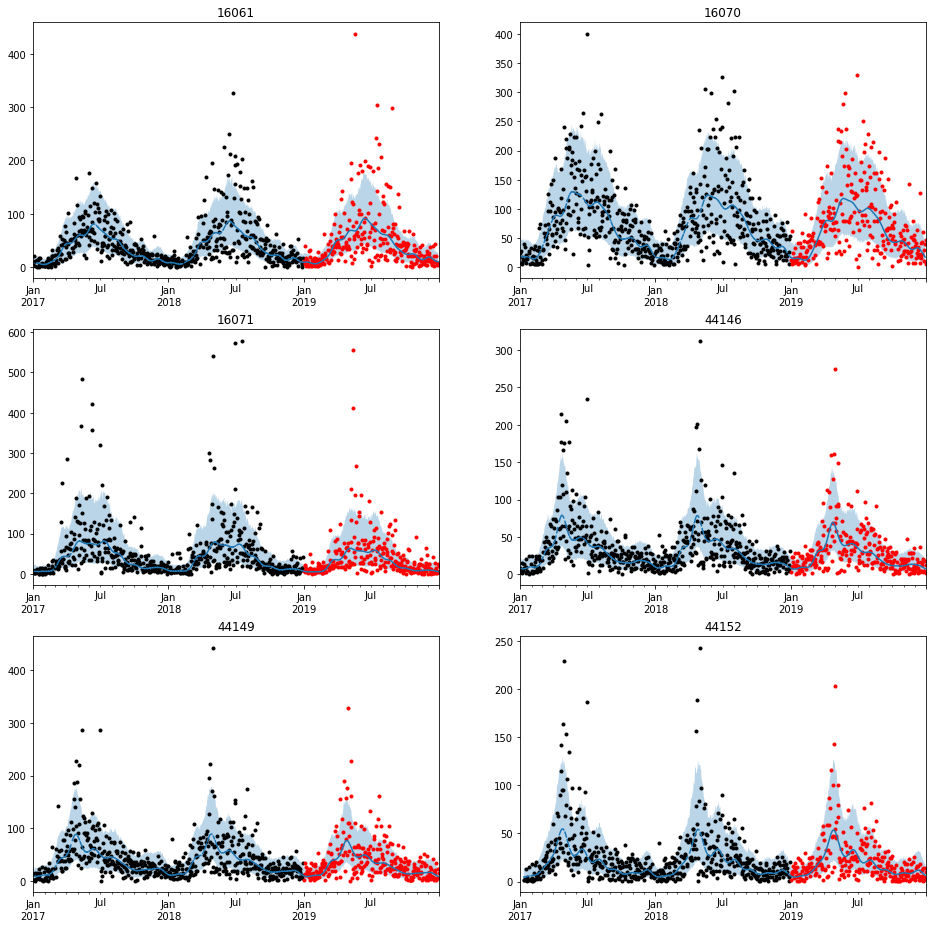

In [165]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

Calculamos el error del pronóstico respecto al conjunto de prueba y usamos eso para determinar el error medio absoluto (MAE) y el error porcentual medio absoluto (MAPE), para cada producto.

In [166]:
error = utils.calculate_error(fcst, test)

In [167]:
mae = error.abs().mean()
mae

16061    26.650334
16070    34.349628
16071    23.811010
44146    15.362168
44149    19.649424
44152    11.610531
dtype: float64

In [168]:
mape = mae / test.mean()
mape

16061    0.550268
16070    0.464206
16071    0.598686
44146    0.515580
44149    0.527980
44152    0.559126
dtype: float64

A modo de resumen, y para más fácil comparación con otros resultados, promediamos los MAE y MAPE de todas las series para obtener un solo valor.

In [169]:
mae.mean()

21.90551568820652

In [170]:
mape.mean()

0.53597420282614

### Con regresores

Probamos de usar el indicador económico como regresor.

In [171]:
indicador = indicador_orig.copy()

In [172]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train, indicador)
fcst = model.predict(steps=365, regressors=indicador).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


Graficamos los pronósticos.

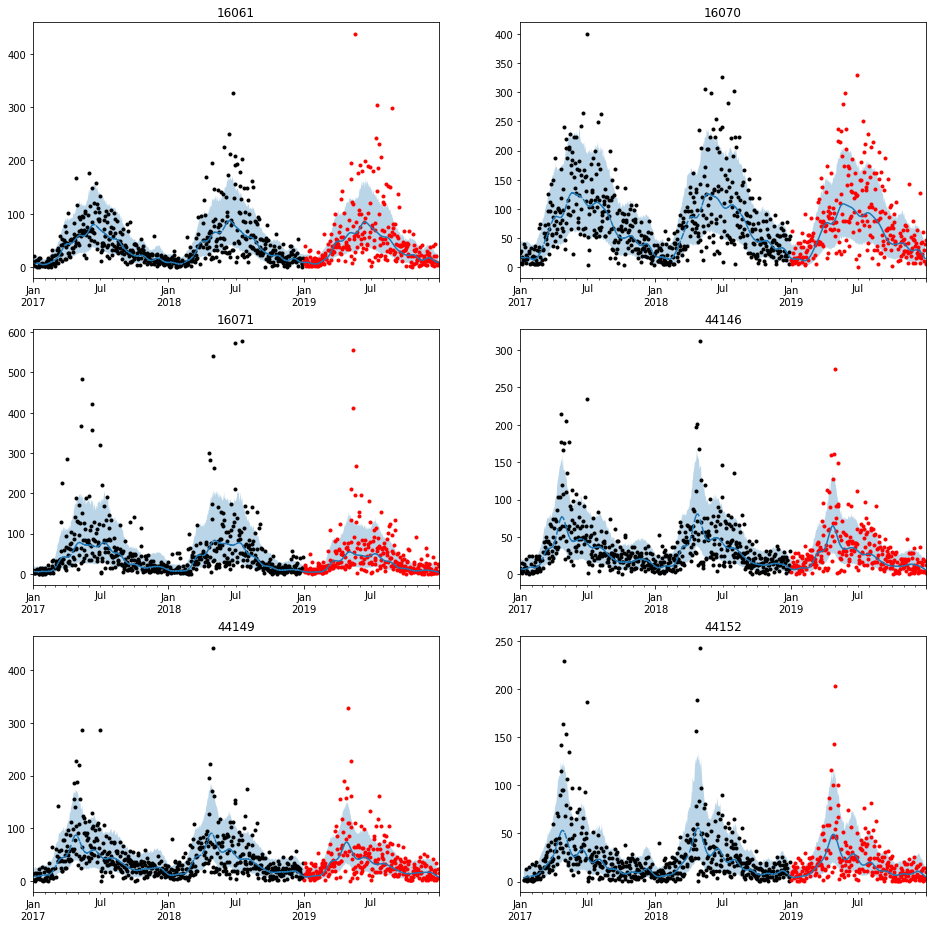

In [173]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

Calculamos los errores.

In [174]:
error_reg = utils.calculate_error(fcst, test)

In [175]:
mae_reg = error_reg.abs().mean()
mae_reg

16061    26.529938
16070    35.042257
16071    24.323758
44146    15.620693
44149    19.804124
44152    11.507714
dtype: float64

In [176]:
mape_reg = mae_reg / test.mean()
mape_reg

16061    0.547782
16070    0.473566
16071    0.611578
44146    0.524256
44149    0.532137
44152    0.554174
dtype: float64

In [177]:
mae_reg.mean()

22.13808067669728

In [178]:
mape_reg.mean()

0.5405822974869393

No hay ninguna mejora respecto al caso sin regresor.

### Con feriados

Se le puede pasar manualmente al modelo una lista de feriados para que use como regresores. También existe la opción de usar una lista predefinida por Prophet. Para este ejemplo usamos la segunda opción.

In [179]:
model = ProphetForecaster(country_holidays="AR", yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


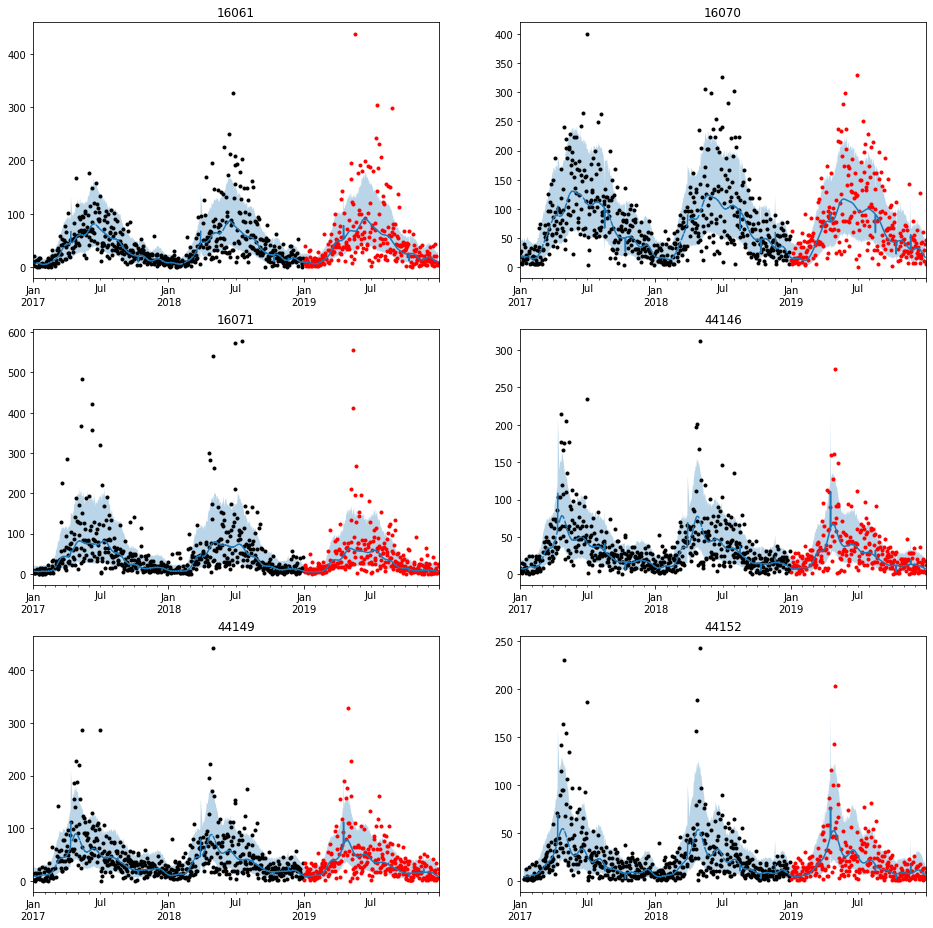

In [180]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [181]:
error_hol = utils.calculate_error(fcst, test)

In [182]:
mae_hol = error_hol.abs().mean()
mae_hol

16061    26.535045
16070    34.453734
16071    23.818956
44146    15.251901
44149    19.415214
44152    11.507173
dtype: float64

In [183]:
mape_hol = mae_hol / test.mean()
mape_hol

16061    0.547887
16070    0.465613
16071    0.598886
44146    0.511879
44149    0.521687
44152    0.554148
dtype: float64

In [184]:
mae_hol.mean()

21.830336999080444

In [185]:
mape_hol.mean()

0.5333500183512294

El resultado es levemente mejor que si no se usaran los feriados, pero no lo suficientemente significativo.

## Pronóstico Semanal

Los pedidos diarios presentan una variabilidad demasiado grande en ciertas épocas del año, generando mucha incertidumbre en el pronóstico. Como alternativa se puede considerar el total de pedidos por semana, obteniendo series con un mejor comportamiento.

In [186]:
train = train_orig.resample("W", closed="left").sum()
test = test_orig.resample("W", closed="left").sum()

In [187]:
train.head()

producto    44152  16061  16070  44146  16071  44149
2017-01-08    0.0   43.0   91.0   32.0   22.0   38.0
2017-01-15    7.0   27.0  100.0   34.0   45.0   46.0
2017-01-22   23.0   47.0   74.0   39.0   34.0   55.0
2017-01-29   19.0   15.0   57.0   28.0   23.0   31.0
2017-02-05   27.0   25.0   85.0   47.0   29.0   55.0

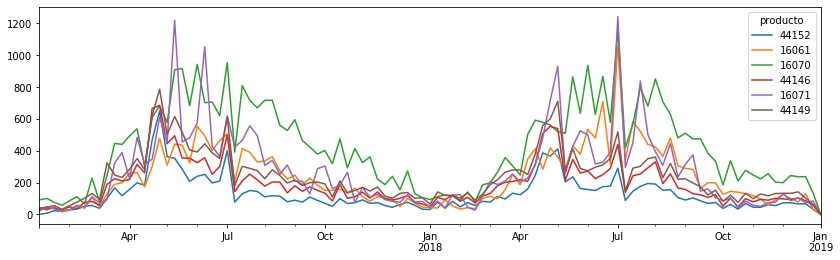

In [188]:
train.plot()

In [189]:
train[train == 0] = np.nan

Ahora ajustamos el modelo para hacer pronósticos con frecuencia semanal, 52 pasos hacia adelante.

In [190]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [191]:
fcst.head()

16061                             16070             \
                 yhat yhat_lower yhat_upper        yhat yhat_lower   
ds                                                                   
2017-01-08  37.217074  21.535514  61.530427   99.057937  57.966388   
2017-01-15  39.405668  22.893012  61.874706   88.611670  48.196197   
2017-01-22  36.923241  20.844757  59.791840   93.967942  54.663776   
2017-01-29  31.616602  17.287000  54.778004  100.742988  57.713596   
2017-02-05  29.723825  16.572467  48.606002   99.013034  55.648057   

                            16071                            44146             \
            yhat_upper       yhat yhat_lower yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  154.869683  44.064672  23.138726  78.608665  40.780695  27.632045   
2017-01-15  139.329117  41.842868  22.553496  74.419323  42.152920  29.208653   
2017-01-22  147.712302  45.921813  24.607294  78.139647  48.850651  33.745298   
2017-01-29  154.940480  49.776153  26.511039  89.852370  55.795280  39.565681   
2017-02-05  155.301193  48.913947  26.388924  89.121296  57.312428  40.053165   

                           44149                             44152             \
           yhat_upper       yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  57.722751  56.271073  38.574083   78.688354        NaN        NaN   
2017-01-15  58.677018  56.962274  39.174306   82.207082  19.491082  12.416498   
2017-01-22  69.694243  63.329898  43.991753   90.071181  23.848156  15.696506   
2017-01-29  79.193036  69.814315  49.160514   98.263849  31.258629  21.018087   
2017-02-05  81.572457  72.790680  49.922073  101.683227  37.620622  25.304959   

                       
           yhat_upper  
ds                     
2017-01-08        NaN  
2017-01-15  29.767168  
2017-01-22  35.444408  
2017-01-29  47.495833  
2017-02-05  56.112655

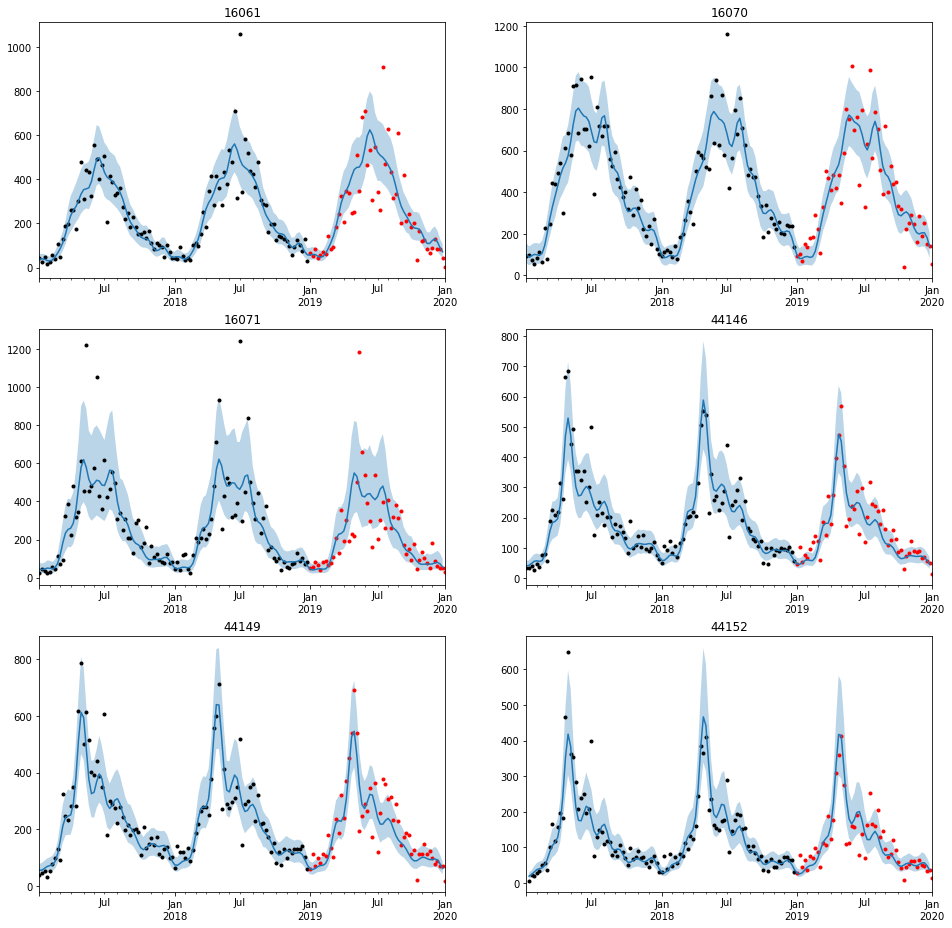

In [192]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

Según las gráficas, el pronóstico se ajusta mejor y tiene más certeza que antes. Podemos verificarlo calculando el error.

In [193]:
error_w = utils.calculate_error(fcst, test)

In [194]:
mae_w = error_w.abs().mean()
mae_w

16061    76.611663
16070    88.668436
16071    89.065099
44146    37.015524
44149    49.374722
44152    31.145868
dtype: float64

In [195]:
mape_w = mae_w / test.mean()
mape_w

16061    0.294169
16070    0.222059
16071    0.403699
44146    0.223952
44149    0.237551
44152    0.274117
dtype: float64

In [196]:
mae_w.mean()

61.98021855379114

In [197]:
mape_w.mean()

0.27592444557453194

Las métricas corroboran que un pronóstico semanal es mejor candidato que uno diario.

A continuación probamos de usar regresores y feriados, al igual que se hizo con el caso diario.

### Con regresores

In [198]:
indicador = indicador_orig.resample("W", closed="left").mean()

In [199]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train, indicador)
fcst = model.predict(steps=52, freq="W", regressors=indicador).asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


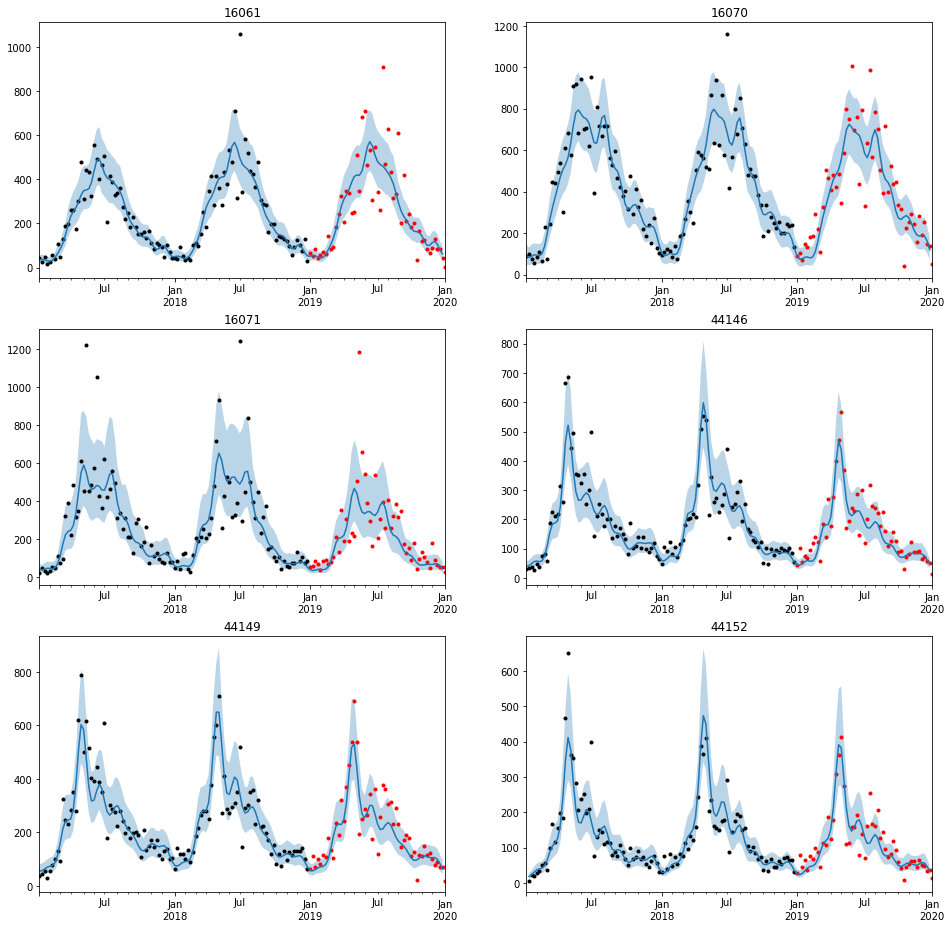

In [200]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [201]:
error_w_reg = utils.calculate_error(fcst, test)

In [202]:
mae_w_reg = error_w_reg.abs().mean()
mae_w_reg

16061    73.431749
16070    91.768705
16071    87.783777
44146    36.690911
44149    48.968597
44152    29.240496
dtype: float64

In [203]:
mape_w_reg = mae_w_reg / test.mean()
mape_w_reg

16061    0.281959
16070    0.229823
16071    0.397891
44146    0.221988
44149    0.235597
44152    0.257347
dtype: float64

In [204]:
mae_w_reg.mean()

61.31403917018756

In [205]:
mape_w_reg.mean()

0.27076764388659486

Con el regresor esta vez se observa una leve mejora, pero sigue sin ser significativa.

### Con feriados

In [206]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True, country_holidays="AR")
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [207]:
fcst.head()

16061                             16070             \
                 yhat yhat_lower yhat_upper        yhat yhat_lower   
ds                                                                   
2017-01-08  39.365004  23.745383  60.021450  103.793016  64.870753   
2017-01-15  40.503937  26.158481  61.452677   91.060099  55.520876   
2017-01-22  37.152947  23.743034  57.004037   94.585139  59.531306   
2017-01-29  31.993502  19.729076  49.645248  101.479365  62.451511   
2017-02-05  30.826487  19.282920  47.613808  101.676945  62.241373   

                            16071                            44146             \
            yhat_upper       yhat yhat_lower yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  155.047630  42.507676  22.596826  73.955214  40.943607  29.587087   
2017-01-15  135.954357  41.119887  23.316338  71.497483  42.283122  29.592689   
2017-01-22  145.066887  44.989154  25.243573  78.158418  48.773287  34.761478   
2017-01-29  156.148136  47.937942  27.180055  85.512721  55.606254  39.408172   
2017-02-05  153.204453  46.907078  27.266885  80.237294  57.336564  40.821835   

                           44149                             44152             \
           yhat_upper       yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  58.655754  56.618572  39.877361   79.283562        NaN        NaN   
2017-01-15  59.730102  57.347622  41.415416   79.814454  19.804649  13.517351   
2017-01-22  69.087616  63.528922  44.444875   85.899104  24.010762  16.201973   
2017-01-29  78.449730  69.898814  50.349822   96.138201  31.414595  21.405842   
2017-02-05  79.807552  73.085383  50.561735  100.169199  38.008497  25.397484   

                       
           yhat_upper  
ds                     
2017-01-08        NaN  
2017-01-15  29.693348  
2017-01-22  35.781212  
2017-01-29  44.573853  
2017-02-05  54.316919

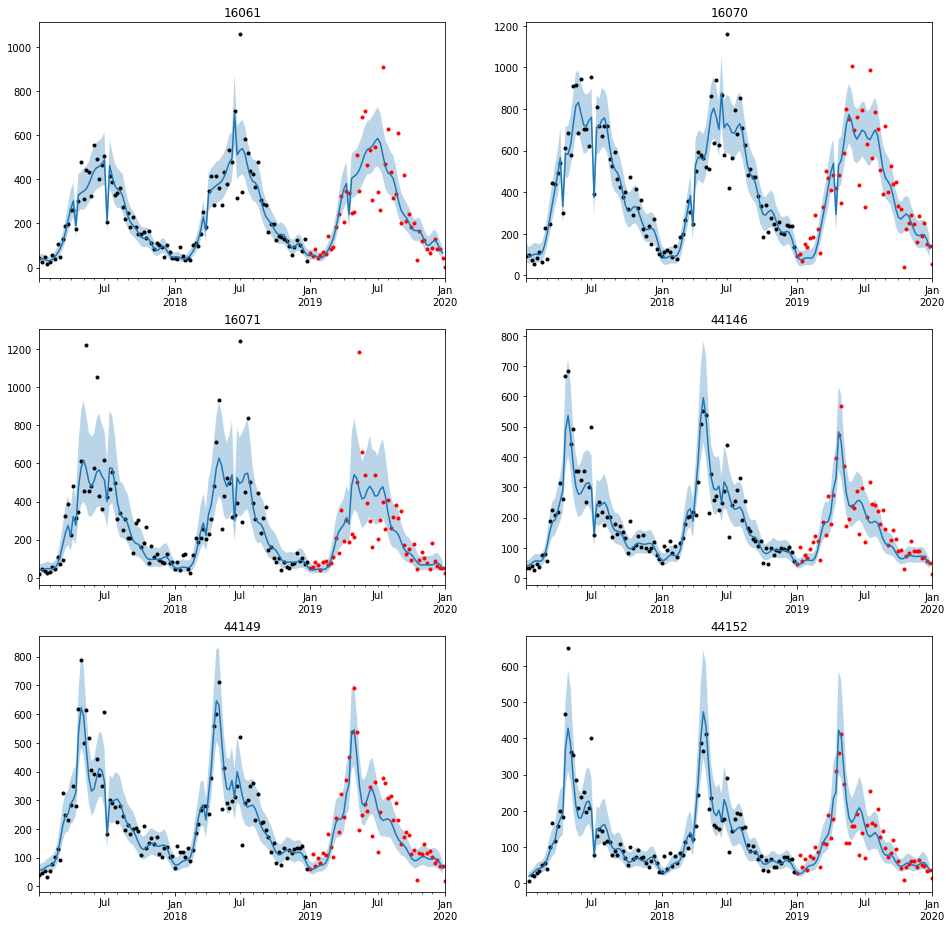

In [208]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [209]:
error_w_hol = utils.calculate_error(fcst, test)

In [210]:
mae_w_hol = error_w_hol.abs().mean()
mae_w_hol

16061    76.723325
16070    92.751029
16071    89.707150
44146    38.820780
44149    49.726462
44152    32.688941
dtype: float64

In [211]:
mape_w_hol = mae_w_hol / test.mean()
mape_w_hol

16061    0.294598
16070    0.232283
16071    0.406609
44146    0.234875
44149    0.239243
44152    0.287697
dtype: float64

In [212]:
mae_w_hol.mean()

63.40294795529612

In [213]:
mape_w_hol.mean()

0.2825508530987506

Esta vez el resultado es peor con los feriados.

Pareciera que no es realmente necesario usar el precio de la nafta o los feriados como regresores, ya que no producen ninguna mejora significativa, tanto en el caso diario como en el caso semanal.

## Pronóstico bisemanal

La metodología es la misma que la usada anteriormente.

In [214]:
train = train_orig.resample("2W", closed="left").sum()
test = test_orig.resample("2W", closed="left").sum()

In [215]:
train.head()

producto    44152  16061  16070  44146  16071  44149
2017-01-15    7.0   70.0  191.0   66.0   67.0   84.0
2017-01-29   42.0   62.0  131.0   67.0   57.0   86.0
2017-02-12   60.0   82.0  196.0   84.0   83.0  132.0
2017-02-26  106.0  144.0  294.0  156.0  158.0  232.0
2017-03-12  138.0  176.0  322.0  246.0  164.0  417.0

In [216]:
train[train == 0] = np.nan

In [217]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=26, freq="2W").asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [218]:
fcst.head()

16061                               16070              \
                  yhat  yhat_lower  yhat_upper        yhat  yhat_lower   
ds                                                                       
2017-01-15   77.601077   60.371731   97.969882  188.934850  142.133134   
2017-01-29   74.889317   58.310284   94.662086  193.190338  143.218332   
2017-02-12   79.298256   63.107022  101.504424  223.258315  166.723661   
2017-02-26  117.450705   93.107726  145.730160  271.352808  210.399769   
2017-03-12  194.846241  158.975548  236.250871  450.993822  371.042542   

                             16071                               44146  \
            yhat_upper        yhat  yhat_lower  yhat_upper        yhat   
ds                                                                       
2017-01-15  242.784561   86.349225   56.772178  127.252455   85.739643   
2017-01-29  253.104120   90.452060   60.213040  133.384619  104.455708   
2017-02-12  283.277519  115.226599   76.232767  176.588162  113.276877   
2017-02-26  339.765924  138.159289   92.676023  203.877791  144.347823   
2017-03-12  534.616907  275.280514  184.945618  392.287809  274.417366   

                                         44149                          \
            yhat_lower  yhat_upper        yhat  yhat_lower  yhat_upper   
ds                                                                       
2017-01-15   66.586786  110.576915  111.781607   87.393359  140.513000   
2017-01-29   80.297745  134.643526  137.049658  105.417266  171.532354   
2017-02-12   87.098950  142.732417  153.540675  120.716227  195.768902   
2017-02-26  112.756521  183.763990  211.929020  169.143205  264.064700   
2017-03-12  220.548909  341.835202  394.447216  318.420861  479.437356   

                 44152                          
                  yhat  yhat_lower  yhat_upper  
ds                                              
2017-01-15   31.300245   19.149546   47.251839  
2017-01-29   58.901338   38.349471   86.918459  
2017-02-12   86.478974   59.000196  122.778554  
2017-02-26   98.325752   67.357077  140.149300  
2017-03-12  168.517780  120.768420  234.339300

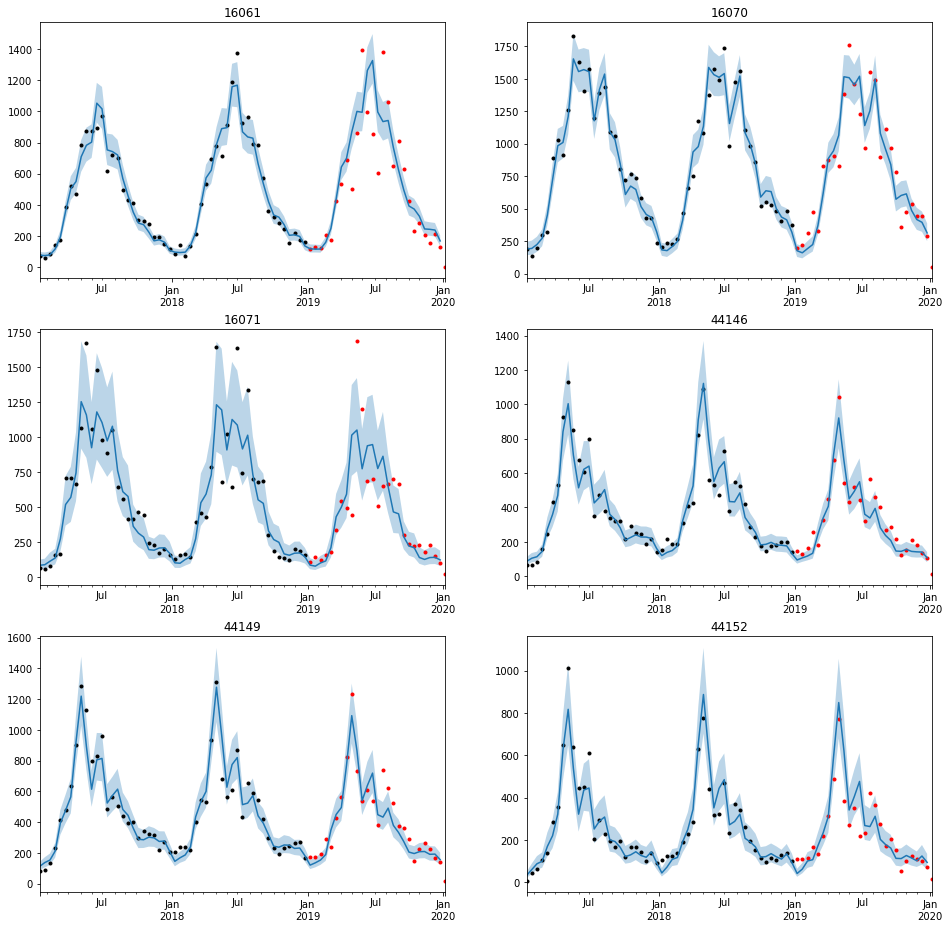

In [219]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [220]:
error_2w = utils.calculate_error(fcst, test)

In [221]:
mae_2w = error_2w.abs().mean()
mae_2w

16061    143.219622
16070    129.017376
16071    145.383331
44146     59.827187
44149     78.051600
44152     61.969942
dtype: float64

In [222]:
mape_2w = mae_2w / test.mean()
mape_2w

16061    0.280151
16070    0.164602
16071    0.335701
44146    0.184399
44149    0.191303
44152    0.277846
dtype: float64

In [223]:
mae_2w.mean()

102.9115097034278

In [224]:
mape_2w.mean()

0.23900031311307726

El ajuste es mejor que en el caso diario y semanal.

### Con regresores

In [225]:
indicador = indicador_orig.resample("2W", closed="left").mean()

In [226]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=26, freq="2W", regressors=indicador).asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


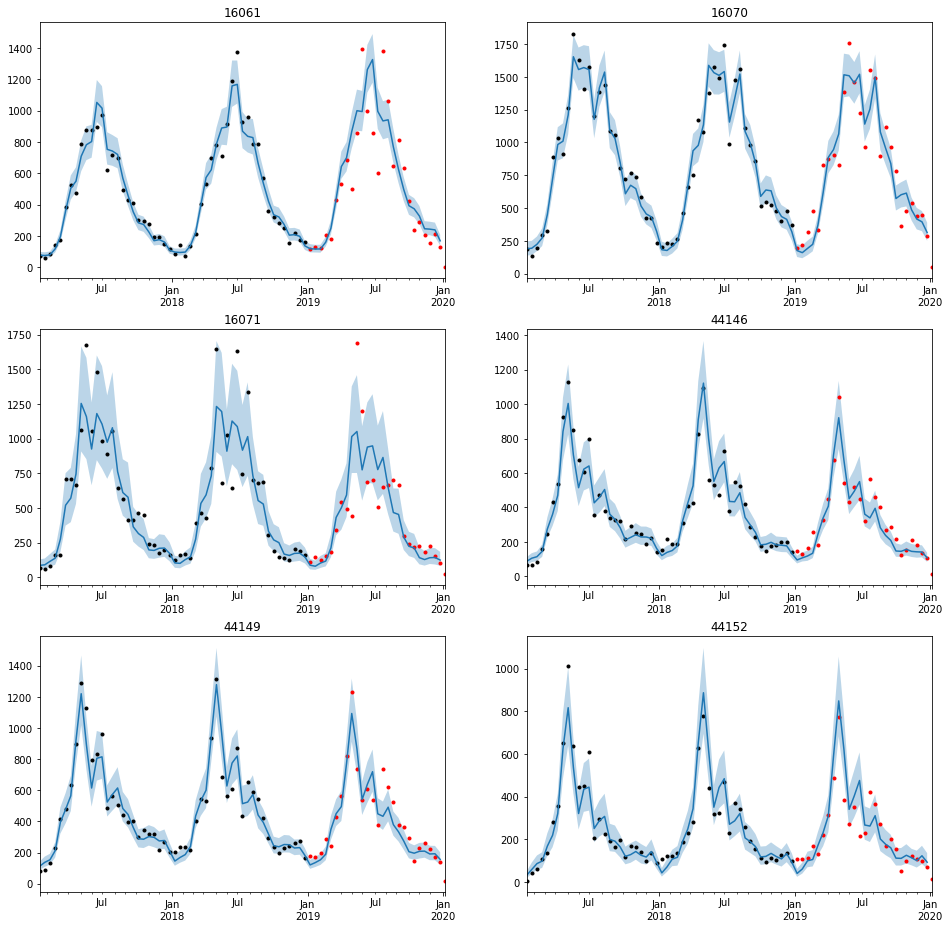

In [227]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [228]:
error_2w_reg = utils.calculate_error(fcst, test)

In [229]:
mae_2w_reg = error_2w_reg.abs().mean()
mae_2w_reg

16061    143.219622
16070    129.017376
16071    145.383331
44146     59.827187
44149     78.051600
44152     61.969942
dtype: float64

In [230]:
mape_2w_reg = mae_2w_reg / test.mean()
mape_2w_reg

16061    0.280151
16070    0.164602
16071    0.335701
44146    0.184399
44149    0.191303
44152    0.277846
dtype: float64

In [231]:
mae_2w_reg.mean()

102.9115097034278

In [232]:
mape_2w_reg.mean()

0.23900031311307726

### Con feriados

In [233]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True, country_holidays="AR")
model.fit(train)
fcst = model.predict(steps=26, freq="2W").asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


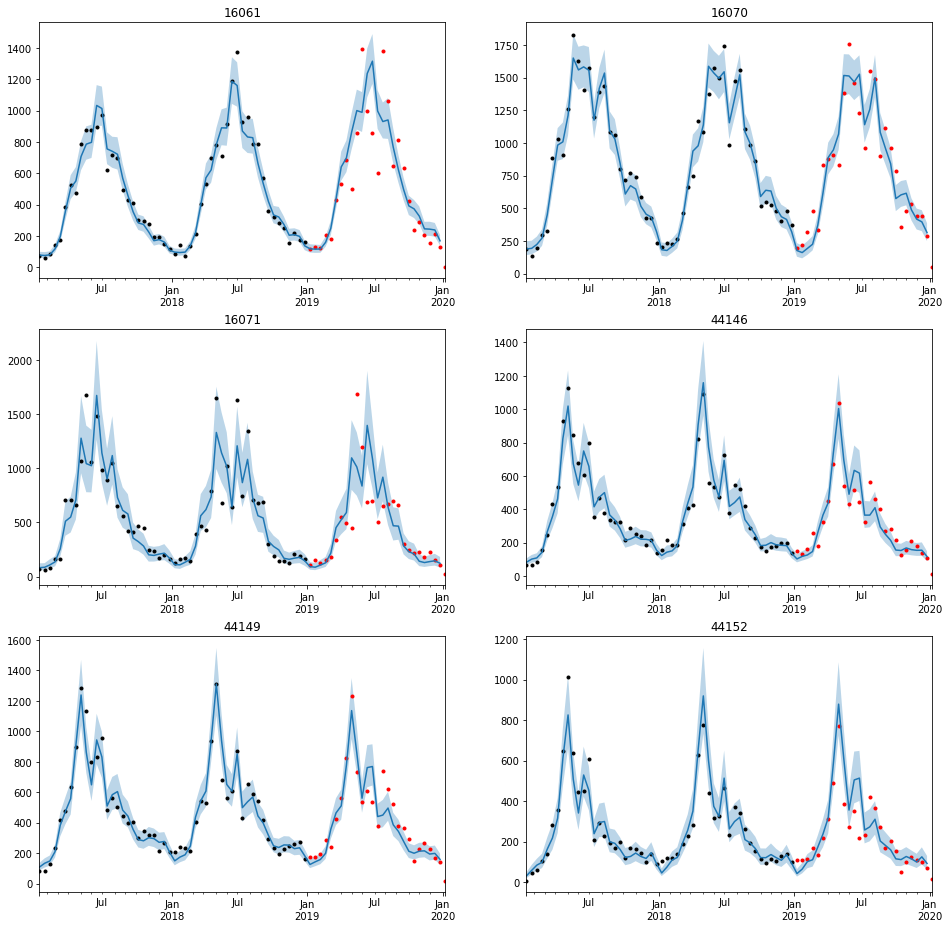

In [234]:
utils.plot_grid_fcst(fcst, train, test, 3, 2, figsize=(16,16))

In [235]:
error_2w_hol = utils.calculate_error(fcst, test)

In [236]:
mae_2w_hol = error_2w_hol.abs().mean()
mae_2w_hol

16061    142.074209
16070    129.121626
16071    169.768146
44146     62.981647
44149     80.253342
44152     67.692150
dtype: float64

In [237]:
mape_2w_hol = mae_2w_hol / test.mean()
mape_2w_hol

16061    0.277911
16070    0.164735
16071    0.392007
44146    0.194122
44149    0.196699
44152    0.303502
dtype: float64

In [238]:
mae_2w_hol.mean()

108.64851997425608

In [239]:
mape_2w_hol.mean()

0.25482927038349656

# Pronóstico por producto y región

Es posible hacer pronósticos agrupados. Para este ejemplo vamos a hacer un pronóstico por producto y región, por lo que creamos la tabla a partir de los datos originales, con las respectivas series.

In [240]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

In [241]:
u_producto_region = u_producto_region.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [242]:
u_producto_region.head()

producto      16034   16061            16062            16070           \
sucursal   santa fe neuquen santa fe neuquen santa fe neuquen santa fe   
2017-01-01      NaN     NaN      NaN     NaN      NaN     NaN      NaN   
2017-01-02      NaN     NaN      7.0     NaN      1.0     NaN     25.0   
2017-01-03      NaN     NaN     21.0     NaN      NaN     NaN     27.0   
2017-01-04      NaN     NaN      NaN     NaN      NaN     NaN      8.0   
2017-01-05      NaN     NaN      3.0     NaN      NaN     NaN      6.0   

producto     16071            16075  ...   44158            90739           \
sucursal   neuquen santa fe neuquen  ... neuquen santa fe neuquen santa fe   
2017-01-01     NaN      NaN     NaN  ...     NaN      NaN     NaN      NaN   
2017-01-02     NaN     11.0     NaN  ...     NaN      NaN     NaN      4.0   
2017-01-03     NaN      2.0     NaN  ...     NaN      NaN     NaN      3.0   
2017-01-04     NaN      4.0     NaN  ...     NaN      1.0     NaN      NaN   
2017-01-05     NaN      3.0     NaN  ...     NaN      1.0     NaN      NaN   

producto     90740            90745            90746           
sucursal   neuquen santa fe neuquen santa fe neuquen santa fe  
2017-01-01     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-02     NaN      1.0     NaN      NaN     NaN      NaN  
2017-01-03     NaN      2.0     NaN      NaN     NaN      NaN  
2017-01-04     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-05     NaN      1.0     NaN      NaN     NaN      NaN  

[5 rows x 120 columns]

Graficamos la información contenida en cada serie.

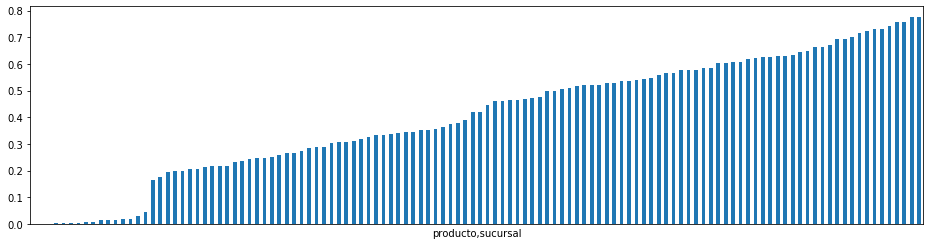

In [243]:
utils.get_amount_info(u_producto_region).plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

Nos quedamos con 12 series que superan el umbral de 0.5.

In [244]:
u_producto_region_forecastable = utils.get_forecastables(u_producto_region, T=0.5, N=12).sort_index(axis=1)

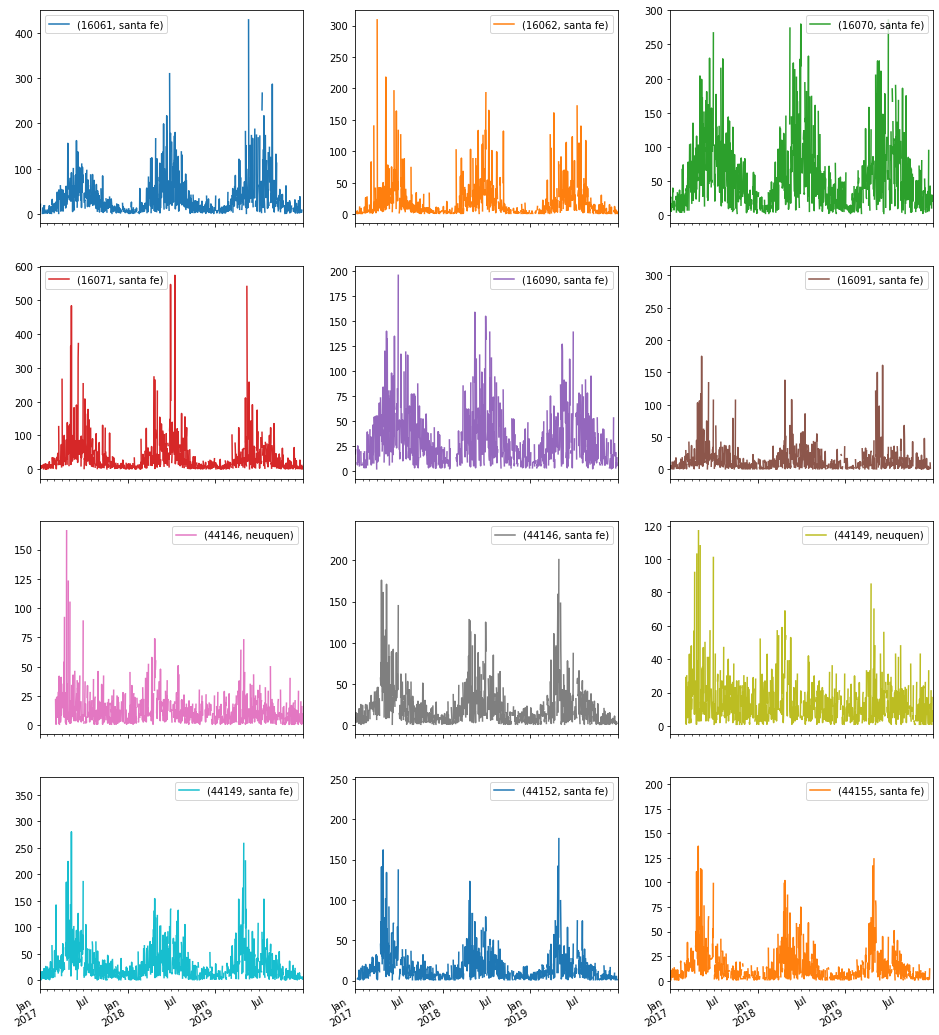

In [245]:
utils.plot_grid(u_producto_region_forecastable, n_cols=3, figsize=(16, 20))

In [246]:
train_orig, test_orig = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

## Pronóstico diario

In [247]:
train = train_orig.copy()
test = test_orig.copy()

In [248]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [249]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.526038  15.961973  2.229475   0.713442   7.197233   
2017-01-03  5.406998   1.482443  16.257230       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.650557  15.963870       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.821311   6.991593   
2017-01-07  5.456751   1.698840  17.071245       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN  2.358351   0.760234   7.556195   
2017-01-10       NaN        NaN        NaN  2.370805   0.822115   8.065726   
2017-01-11  5.395641   1.663717  16.328782  2.379988   0.807907   7.897501   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.300835  40.687010  5.567765  ...        NaN   
2017-01-03  14.656313   4.491244  38.555474  5.496262  ...        NaN   
2017-01-04  14.414836   4.558000  39.550056  5.432328  ...        NaN   
2017-01-05  14.227067   3.755396  39.032480  5.375307  ...        NaN   
2017-01-06  14.089813   4.186320  37.728424       NaN  ...        NaN   
2017-01-07  13.999225   3.836611  38.117666  5.279075  ...        NaN   
2017-01-08        NaN        NaN        NaN       NaN  ...        NaN   
2017-01-09        NaN        NaN        NaN  5.201425  ...        NaN   
2017-01-10  13.960102   4.138468  38.122962  5.167639  ...        NaN   
2017-01-11  14.006174   4.074031  35.298781  5.136246  ...        NaN   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.859500   2.111148  26.150181       NaN        NaN        NaN   
2017-01-03  7.707466   1.907993  27.261641       NaN        NaN        NaN   
2017-01-04  7.570713   2.096036  25.668936       NaN        NaN        NaN   
2017-01-05  7.449867   1.963800  22.937689       NaN        NaN        NaN   
2017-01-06  7.345328   1.849609  23.883203       NaN        NaN        NaN   
2017-01-07  7.257265   1.973209  22.308566       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-10  7.090192   1.904167  22.471042       NaN        NaN        NaN   
2017-01-11  7.065153   1.783364  24.107281  3.503355   1.105828  11.838356   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.252816  11.897107  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.120717  11.250228  
2017-01-05  3.942978   1.206987  12.224864  
2017-01-06       NaN        NaN        NaN  
2017-01-07  3.979607   1.315476  12.273081  
2017-01-08       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN  
2017-01-10  3.954297   1.280336  12.276427  
2017-01-11  3.923883   1.266347  10.850658  

[10 rows x 36 columns]

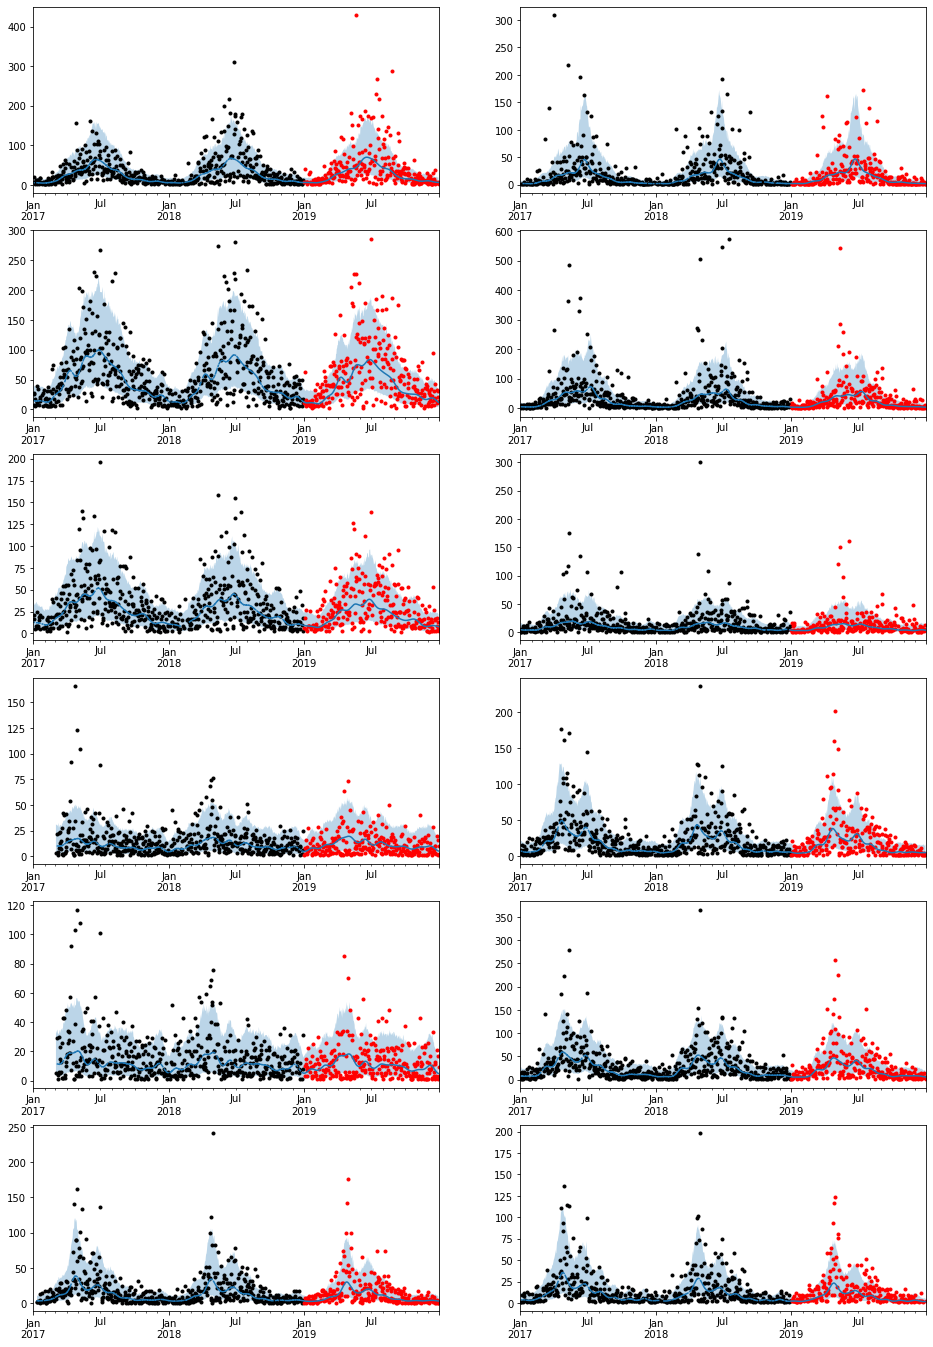

In [250]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

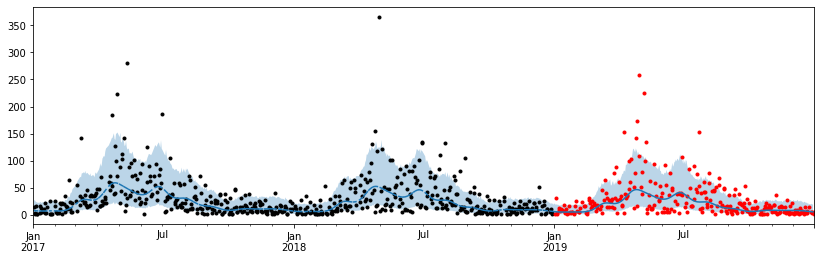

In [251]:
item = (44149, "santa fe")
utils.plot_fcst(fcst[item], train[item], test[item])

In [252]:
error2 = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae2 = error2.abs().mean()
mae2

16061  santa fe    25.558465
16062  santa fe    12.729719
16070  santa fe    29.831057
16071  santa fe    21.205558
16090  santa fe    16.159134
16091  santa fe     9.290050
44146  neuquen      7.612806
       santa fe    13.220995
44149  neuquen      8.371939
       santa fe    16.696083
44152  santa fe     9.854637
44155  santa fe     8.601494
dtype: float64

In [253]:
mape2 = mae2 / test.mean()
mape2

16061  santa fe    0.610620
16062  santa fe    0.664553
16070  santa fe    0.539929
16071  santa fe    0.663556
16090  santa fe    0.558593
16091  santa fe    0.695791
44146  neuquen     0.666833
       santa fe    0.636764
44149  neuquen     0.655385
       santa fe    0.622214
44152  santa fe    0.638972
44155  santa fe    0.631185
dtype: float64

In [254]:
mae2.mean()

14.927661483012391

In [255]:
mape2.mean()

0.6320329700821393

## Pronóstico Semanal

In [256]:
train = train_orig.resample("W", closed="left").sum()
test = test_orig.resample("W", closed="left").sum()

In [257]:
train[train == 0] = np.nan

In [258]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [259]:
fcst.head(10)

16061                             16062             \
             santa fe                          santa fe              
                 yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                   
2017-01-08  28.737316  17.668508   46.637455   7.147390   3.293275   
2017-01-15  29.383838  17.991278   45.516177  11.009872   5.473695   
2017-01-22  26.754222  16.242760   42.359583  16.096677   7.348330   
2017-01-29  22.986237  13.669146   36.816251  16.262881   7.655903   
2017-02-05  22.511850  13.727326   35.675348  13.202090   6.415706   
2017-02-12  27.760216  17.226534   44.650510  13.297726   6.226632   
2017-02-19  38.670791  24.456270   60.648034  20.351978   9.719279   
2017-02-26  51.560481  34.446802   79.957572  36.225313  19.287587   
2017-03-05  63.277434  41.223840   95.333006  53.286476  28.638108   
2017-03-12  77.875179  52.284073  121.281946  62.667585  34.258509   

                             16070                               16071  ...  \
                          santa fe                            santa fe  ...   
            yhat_upper        yhat  yhat_lower  yhat_upper        yhat  ...   
ds                                                                      ...   
2017-01-08   14.993418   79.872895   48.026541  122.741933   34.744823  ...   
2017-01-15   21.971131   69.755474   43.650896  109.093031   33.078678  ...   
2017-01-22   30.087158   68.749193   41.062093  106.961181   34.830568  ...   
2017-01-29   31.081643   68.305400   40.667579  104.363144   35.806089  ...   
2017-02-05   26.541678   66.663715   38.101154  101.579654   34.796665  ...   
2017-02-12   26.939031   70.248828   41.846154  109.145324   35.087332  ...   
2017-02-19   38.687271   86.287100   53.059370  133.870687   41.192957  ...   
2017-02-26   68.308997  115.672658   76.427645  172.807285   57.520012  ...   
2017-03-05   98.467230  148.579453   98.426789  213.657761   87.331421  ...   
2017-03-12  111.555669  174.389446  118.807181  250.524444  126.997807  ...   

                 44149                                          44152  \
               neuquen    santa fe                           santa fe   
            yhat_upper        yhat  yhat_lower  yhat_upper       yhat   
ds                                                                      
2017-01-08         NaN   47.428437   33.537541   66.316121        NaN   
2017-01-15         NaN   47.400816   33.292190   67.464252  15.679476   
2017-01-22         NaN   47.561319   34.291080   70.493021  18.229268   
2017-01-29         NaN   47.776013   34.317266   67.809671  22.672106   
2017-02-05         NaN   50.508649   35.374391   72.833461  27.560892   
2017-02-12         NaN   58.916090   41.803470   84.704333  31.927044   
2017-02-19         NaN   75.435320   53.221910  112.327662  36.601950   
2017-02-26         NaN  100.239416   69.390465  145.778396  43.466501   
2017-03-05   80.268142  129.074404   88.265417  191.579992  53.423445   
2017-03-12  112.397693  153.625647  105.151699  228.429640  64.465937   

                                      44155                        
                                   santa fe                        
           yhat_lower yhat_upper       yhat yhat_lower yhat_upper  
ds                                                                 
2017-01-08        NaN        NaN  17.621967  12.715574  24.701753  
2017-01-15  10.823593  22.652919  16.134479  11.579334  22.594367  
2017-01-22  12.446088  25.995363  16.060772  11.467769  22.713114  
2017-01-29  15.134641  33.023629  18.191021  12.984070  25.462710  
2017-02-05  18.651587  41.036857  23.211742  16.804274  33.363593  
2017-02-12  21.614299  48.126609  30.622220  21.613814  44.598841  
2017-02-19  24.780485  54.567010  37.809419  26.478340  56.619662  
2017-02-26  28.903320  67.585804  43.033943  29.719058  64.670521  
2017-03-05  36.090389  81.787702  48.695650  33.592997  74.296780  
2017-03-12  42.645275

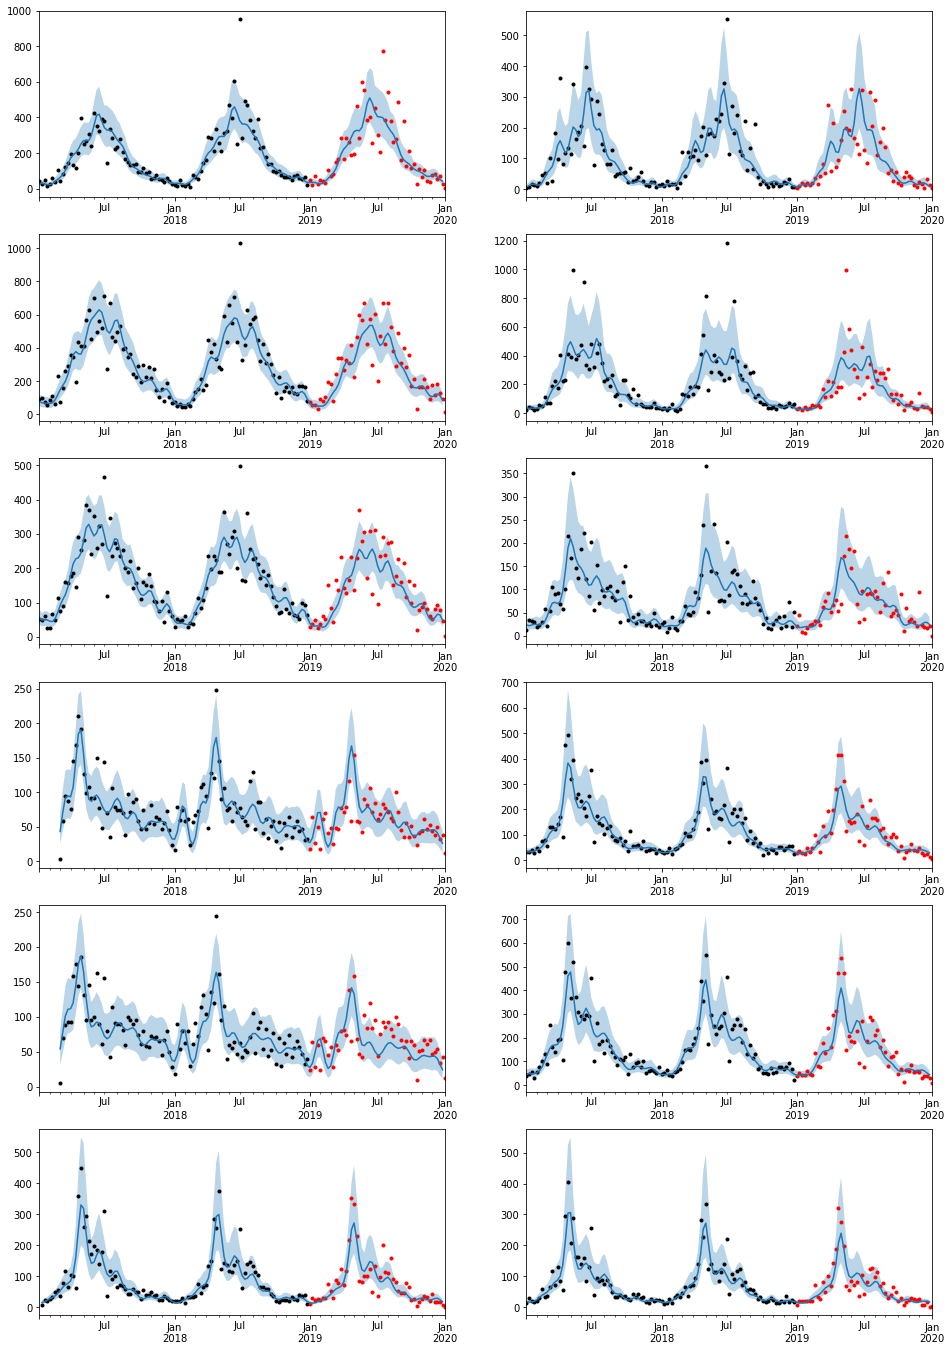

In [260]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [261]:
error2_w = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae2_w = error2_w.abs().mean()
mae2_w

16061  santa fe    68.010121
16062  santa fe    41.045263
16070  santa fe    74.371793
16071  santa fe    74.139526
16090  santa fe    41.933665
16091  santa fe    23.616511
44146  neuquen     18.019114
       santa fe    31.956286
44149  neuquen     21.685335
       santa fe    41.843587
44152  santa fe    24.488106
44155  santa fe    21.648700
dtype: float64

In [262]:
mape2_w = mae2_w / test.mean()
mape2_w

16061  santa fe    0.324967
16062  santa fe    0.430176
16070  santa fe    0.262291
16071  santa fe    0.436018
16090  santa fe    0.289914
16091  santa fe    0.370537
44146  neuquen     0.310978
       santa fe    0.297712
44149  neuquen     0.333234
       santa fe    0.293077
44152  santa fe    0.317560
44155  santa fe    0.340874
dtype: float64

In [263]:
mae2_w.mean()

40.229834062309585

In [264]:
mape2_w.mean()

0.33394481595848885